In [3]:
TF_ENABLE_ONEDNN_OPTS=0

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go

In [5]:
cwd = os.getcwd()
root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(cwd))))

In [6]:
data = pd.read_csv(os.path.join(root_dir,'Dataset/combine.csv'))

In [7]:
X = data.drop(['Height cm (H)','Width cm (W)','Lower Angle (L)','Upper Angle (U)','Internal Angle (Right,2nd)','Leave Model'],axis=1)
y = data['Leave Model']

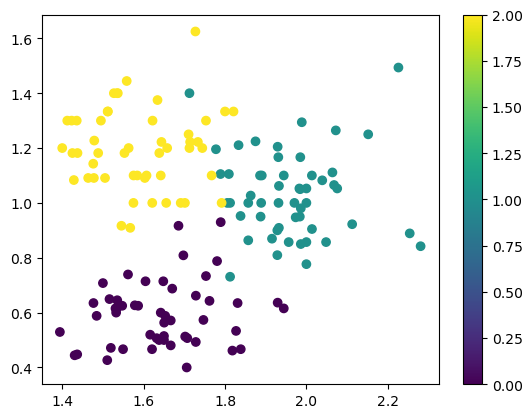

In [17]:
plt.scatter(X['Ratio (H/W)'], X['Ratio(L/U)'], c=y)
plt.colorbar()
plt.show()

In [8]:
# Feature Scalling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)
X = pd.DataFrame(x_scaled, columns=['Ratio (H/W)','Ratio(L/U)','Ratio(L/I)'])

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16,activation='relu',input_shape=(3,)))
    
    hp_units = hp.Int('units',min_value=32,max_value=512,step=32)
    for i in range(hp.Int('num_layers',1,20)):
        model.add(tf.keras.layers.Dense(units=hp_units,activation='relu'))
        
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=['accuracy'])
    
    return model

In [11]:
from keras_tuner import RandomSearch
tuner = RandomSearch(build_model, objective='val_accuracy',max_trials=20, executions_per_trial=3, directory='',project_name='logs')

In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [15]:
tuner.search(X_train, y_train,
             epochs=500,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping])

Trial 20 Complete [00h 00m 38s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 05m 53s


In [25]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model.keras')

In [18]:
# Evaluate the best model on the validation data
val_loss, val_accuracy = best_model.evaluate(X_test, y_test)

# Print the validation loss and accuracy
print('Validation loss: ', val_loss)
print('Validation accuracy: ', val_accuracy)

1/1 [==============================] - 0s 39ms/step - loss: 0.0644 - accuracy: 1.0000
Validation loss:  0.06437902897596359
Validation accuracy:  1.0


In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'units': 384, 'num_layers': 20, 'learning_rate': 0.0001}


In [28]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

with open('trial_id.txt','w') as f:
    f.write(best_trial.trial_id)

In [39]:
import glob
import json

files = glob.glob('logs/**/trial*.json', recursive=True)

steps = []
val_losses = []
val_accuracies = []
train_accuracies = []
trial_numbers = []

for i,file in enumerate(files,start=0):
    with open(file,'r') as f:
        data = json.load(f)
        
        step = data['metrics']['metrics']['val_loss']['observations'][0]['step']
        val_loss = data['metrics']['metrics']['val_loss']['observations'][0]['value'][0]
        val_accuracy = data['metrics']['metrics']['val_accuracy']['observations'][0]['value'][0]
        train_accuracy = data['metrics']['metrics']['accuracy']['observations'][0]['value'][0]
        
        steps.append(step)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)
        trial_number = file.split('/')[1].split('_')[1]
        trial_numbers.append(trial_number) 

In [40]:
trace1 = go.Scatter(x=steps, y=train_accuracies, mode='lines+markers', name='Training Accuracy',text=trial_numbers)
trace2 = go.Scatter(x=steps, y=val_losses, mode='lines+markers', name='Validation Loss',text=trial_numbers)
trace3 = go.Scatter(x=steps, y=val_accuracies, mode='lines+markers', name='Validation Accuracy',text=trial_numbers)

# Create a layout
layout = go.Layout(title='Analysis', xaxis=dict(title='Epoch'), yaxis=dict(title='Value'))

# Create a Figure and add the traces
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Show the figure
fig.show()